In [11]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [4]:
df = pd.read_csv('data/shopping_trends.csv')

df1 = pd.read_csv('data/shopping_trends_updated.csv')

In [7]:
df1.columns

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Shipping Type',
       'Discount Applied', 'Promo Code Used', 'Previous Purchases',
       'Payment Method', 'Frequency of Purchases'],
      dtype='object')

In [5]:
df1.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [13]:
df1.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [15]:
#find amount of duplicates
# identify the duplicated rows based on all columns
dups = df1.duplicated()

# count the number of duplicated rows
dup_count = dups.sum()

dup_count

0

In [18]:
colors = ["#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6"]

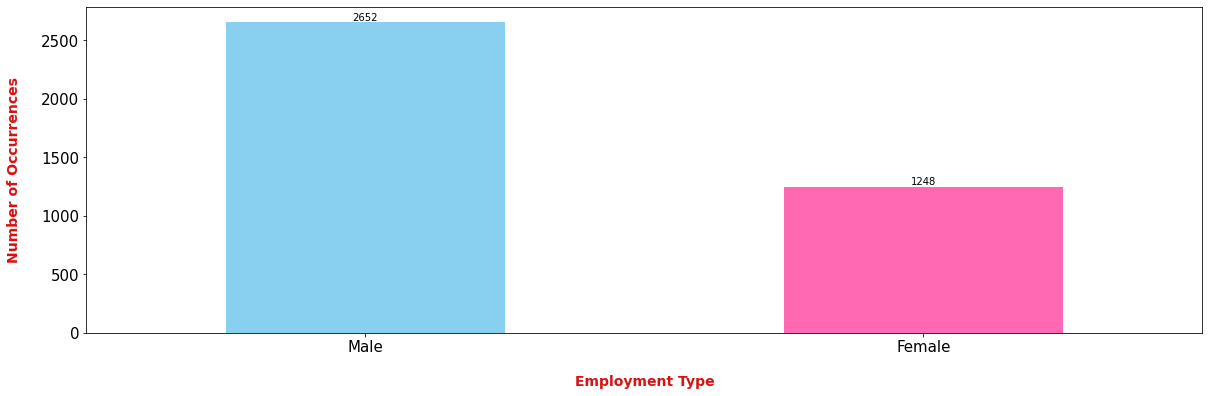

In [19]:
plt.figure(figsize = (20, 6))
ax = df1["Gender"].value_counts().plot(kind = 'bar', color = colors, rot = 0)
ax.set_xticklabels(('Male', 'Female'))

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'black')
    ax.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Employment Type', weight = "bold", color = "#D71313", fontsize = 14, labelpad = 20)
plt.ylabel('Number of Occurrences', weight = "bold", color = "#D71313", fontsize = 14, labelpad = 20);

In [20]:
# # Group data by "Item Purchased" and calculate the sum of "Purchase Amount USD"
# grouped_data = df1.groupby("Item Purchased")["Purchase Amount (USD)"].sum()

# # Create a bar chart
# plt.bar(grouped_data.index, grouped_data.values)
# plt.xlabel("Item Purchased")
# plt.ylabel("Purchase Amount USD")
# plt.title("Purchase Amount USD by Item Purchased")

# # Display the chart
# plt.show()

In [23]:
gender_counts = df1['Gender'].value_counts(normalize=True)
gender_counts

Male      0.68
Female    0.32
Name: Gender, dtype: float64

In [25]:
category_counts = df1['Category'].value_counts(normalize=True)
category_counts

Clothing       0.445385
Accessories    0.317949
Footwear       0.153590
Outerwear      0.083077
Name: Category, dtype: float64

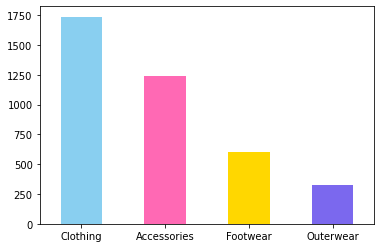

In [32]:
ax = df1['Category'].value_counts().plot(kind='bar',color = colors,rot=0)

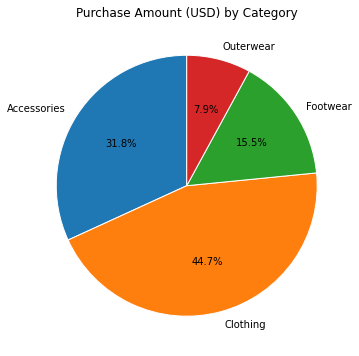

In [35]:
category_purchase_sum = df1.groupby("Category")["Purchase Amount (USD)"].sum()

# Create a pie chart
plt.figure(figsize=(6, 6))
category_purchase_sum.plot.pie(autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'})
plt.title("Purchase Amount (USD) by Category")
plt.ylabel("")  # Remove the default label for the y-axis

# Display the pie chart
plt.show()

In [41]:
# Average age of customer

average_age = df1['Age'].mean()

avg_by_gender = df1.groupby('Gender')['Age'].mean()

print(avg_by_gender)

Gender
Female    44.007212
Male      44.097285
Name: Age, dtype: float64


In [48]:
# most purchased item

# ['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
#        'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
#        'Review Rating', 'Subscription Status', 'Shipping Type',
#        'Discount Applied', 'Promo Code Used', 'Previous Purchases',
#        'Payment Method', 'Frequency of Purchases']

most_purchased = df1['Item Purchased'].value_counts()
print(most_purchased)


Blouse        171
Pants         171
Jewelry       171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Scarf         157
Shorts        157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: Item Purchased, dtype: int64


In [49]:
category_purchase_sum

Category
Accessories     74200
Clothing       104264
Footwear        36093
Outerwear       18524
Name: Purchase Amount (USD), dtype: int64

In [51]:
# What is the average review rating for male customers and female customers separately ?


rev_rating = df1.groupby("Gender")['Review Rating'].mean()

print("Average review rating by gender:\n", rev_rating)

Average review rating by gender:
 Gender
Female    3.741426
Male      3.753959
Name: Review Rating, dtype: float64


In [64]:
# What is the most common payment method used by customers ?
most_common_payment = df1['Payment Method'].value_counts()
most_common_payment_method = df1['Payment Method'].mode()[0]
most_common_payment_method
# most_common_payment


'PayPal'

In [66]:
# What is the median purchase amount (USD) ?

df1['Purchase Amount (USD)'].median()

60.0

In [67]:
# How many customers have opted for the Subscription ?
df1['Subscription Status'].value_counts()

No     2847
Yes    1053
Name: Subscription Status, dtype: int64

In [72]:
# What is the average purchase amount for customers with a subscription status of 'Yes' and 'No' ?

yvn= df1.groupby('Subscription Status')['Purchase Amount (USD)'].mean()
print(yvn)

Subscription Status
No     59.865121
Yes    59.491928
Name: Purchase Amount (USD), dtype: float64


In [75]:
# What is the most common season for purchases ?
most_common_season = df['Season'].mode()[0]
season = df1['Season'].value_counts()
season

Spring    999
Fall      975
Winter    971
Summer    955
Name: Season, dtype: int64

In [76]:
# What is the total purchase amount for each gender ?
df1.groupby('Gender')['Purchase Amount (USD)'].sum()

Gender
Female     75191
Male      157890
Name: Purchase Amount (USD), dtype: int64

In [87]:
# What is the average age of customers who made purchases in the Summer season ?
df1[df1['Season']=='Summer']['Age'].mean()

43.973821989528794

In [88]:
# How many customers used a promo code for their purchase ?
promo_code_count = df1[df1['Promo Code Used'] == 'Yes']['Customer ID'].count()
promo_code_count

1677

In [86]:
# What is the maximum and minimum review rating in the dataset ?
max_review = df1['Review Rating'].max()
min_review = df1['Review Rating'].min()

print("Max:", max_review, "\nMin:", min_review)

Max: 5.0 
Min: 2.5


In [ ]:
# ['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
#        'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
#        'Review Rating', 'Subscription Status', 'Shipping Type',
#        'Discount Applied', 'Promo Code Used', 'Previous Purchases',
#        'Payment Method', 'Frequency of Purchases']

In [90]:
# What is the most common shipping type for customers with a review rating above 4 ?
df1[df1['Review Rating']>4]['Shipping Type'].mode()[0]

'Standard'

In [98]:
# How many customers have made more than 30 previous purchases ?
df1[df1['Previous Purchases']>30]['Customer ID'].count()

# df1['Customer ID'].count()>30

1549

In [100]:
# What is the average purchase amount for customers who have made more than 30 previous purchases ?

df1[df1['Previous Purchases']>30]['Purchase Amount (USD)'].mean()

60.02840542285345

In [101]:
# What is the most common payment method for customers who shop in the Winter season ?
# df1[df1['Review Rating']>4]['Shipping Type'].mode()[0]
df1[df1['Season']=='Winter']['Payment Method'].value_counts()

PayPal           189
Credit Card      174
Bank Transfer    163
Cash             155
Venmo            152
Debit Card       138
Name: Payment Method, dtype: int64

In [102]:
df1[df1['Season']=='Winter']['Payment Method'].mode()[0]

'PayPal'

In [103]:
# What is the total purchase amount for customers in each location ?
df1.groupby("Location")['Purchase Amount (USD)'].sum()

Location
Alabama           5261
Alaska            4867
Arizona           4326
Arkansas          4828
California        5605
Colorado          4222
Connecticut       4226
Delaware          4758
Florida           3798
Georgia           4645
Hawaii            3752
Idaho             5587
Illinois          5617
Indiana           4655
Iowa              4201
Kansas            3437
Kentucky          4402
Louisiana         4848
Maine             4388
Maryland          4795
Massachusetts     4384
Michigan          4533
Minnesota         4977
Mississippi       4883
Missouri          4691
Montana           5784
Nebraska          5172
Nevada            5514
New Hampshire     4219
New Jersey        3802
New Mexico        5014
New York          5257
North Carolina    4742
North Dakota      5220
Ohio              4649
Oklahoma          4376
Oregon            4243
Pennsylvania      4926
Rhode Island      3871
South Carolina    4439
South Dakota      4236
Tennessee         4772
Texas             4712
Ut

In [106]:
# What is the average purchase amount for customers who have a subscription and used Venmo as the payment method ?

df1[(df1["Subscription Status"]=="Yes")&(df1['Payment Method']=="Venmo")]['Purchase Amount (USD)'].mean()

57.51149425287356

In [108]:
# What is the frequency distribution of the 'Frequency of Purchases' column ?
df1['Frequency of Purchases'].value_counts()

Every 3 Months    584
Annually          572
Quarterly         563
Monthly           553
Bi-Weekly         547
Fortnightly       542
Weekly            539
Name: Frequency of Purchases, dtype: int64

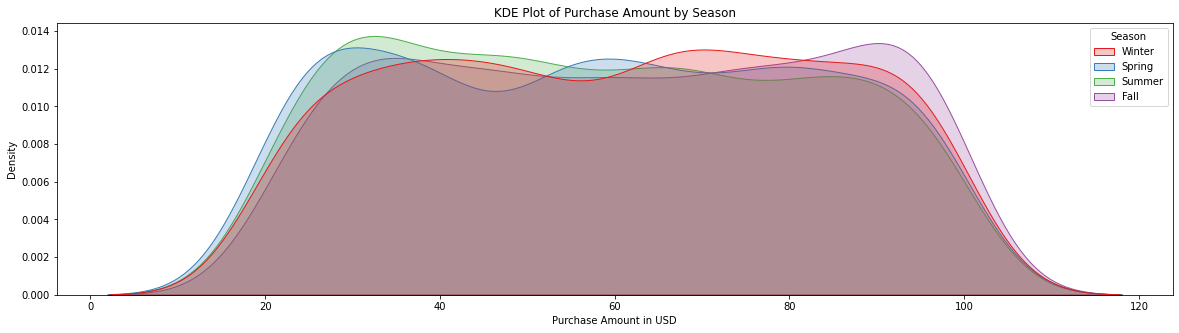

In [110]:
# KDE plot for Purchase Amount by Season
import seaborn as sns
plt.figure(figsize=(20, 5))
sns.kdeplot(data = df, x = 'Purchase Amount (USD)', hue = 'Season', common_norm = False, fill = True, palette = 'Set1')
plt.title('KDE Plot of Purchase Amount by Season')
plt.xlabel('Purchase Amount in USD')
plt.show()

In [111]:
# How many customers have made a purchase in each category?
df['Category'].value_counts()

Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: Category, dtype: int64

In [113]:
# correlation_age_previous_purchases = df['Age'].corr(df['Previous Purchases'], method='pearson')

correlation_age_prev_purchases = df1['Age'].corr(df1['Previous Purchases'],method='pearson')
print("Pearson Correlation between Age and Previous Purchases:", correlation_age_prev_purchases)

Pearson Correlation between Age and Previous Purchases: 0.04044453114289462


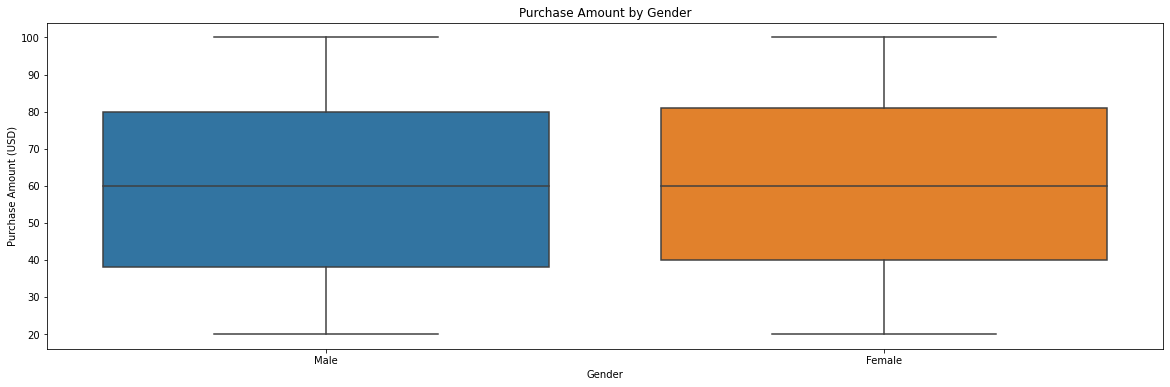

In [119]:
# Box Plot of Purchase Amount by Gender
plt.figure(figsize = (20, 6))
sns.boxplot(x="Gender",y="Purchase Amount (USD)",data=df1)
plt.title('Purchase Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Purchase Amount (USD)')
plt.show()

<Figure size 1440x432 with 0 Axes>

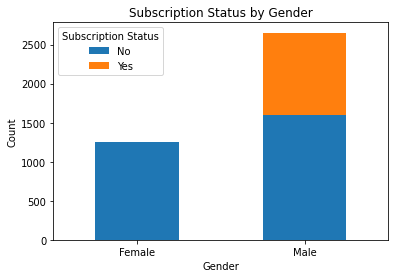

In [120]:
subscription_gender_counts = df.groupby(['Gender', 'Subscription Status']).size().unstack()
plt.figure(figsize = (20, 6))
subscription_gender_counts.plot(kind='bar', stacked=True, rot = 0);
plt.title('Subscription Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();

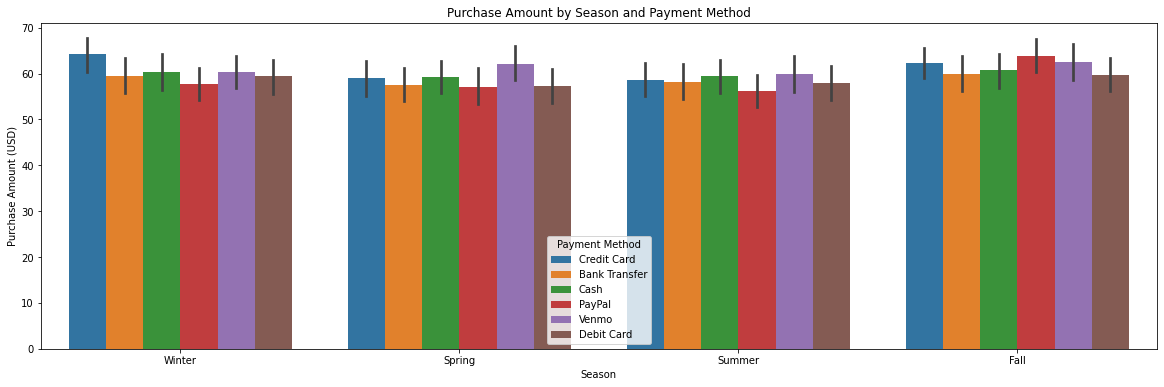

In [123]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Season', y='Purchase Amount (USD)', hue='Payment Method', data=df)
plt.title('Purchase Amount by Season and Payment Method')
plt.xlabel('Season')
plt.ylabel('Purchase Amount (USD)')
plt.xticks(rotation = 0)
plt.show()